# Computing the error between data and true model

## Import libraries

In [3]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint

## Define cell cycle model

In [79]:
# CELL CYCLE MODELS
### advanced_Ki67_cycle_model = 0
### basic_Ki67_cycle_model = 1
### flow_cytometry_cycle_model = 2
### live_apoptotic_cycle_model = 3
### total_cells_cycle_model = 4
### live_cells_cycle_model = 5 
### flow_cytometry_separated_cycle_model = 6
### cycling_quiescent_model = 7
cycle_model = 0

# output_folder = "output_Live/"
# output_folder = "output_Ki67_Basic/"
output_folder = "output_Ki67_Advanced_Apoptosis/"
# output_folder = "output_Flow_Cytometry/"
# output_folder = "output_Separated_Flow_Cytometry/"

## Read *.csv* file

In [80]:
data_filename = "data_fraction.csv"

data = np.genfromtxt(output_folder + data_filename, dtype = float, delimiter = ',', names = True)
times = data["times"]

if cycle_model == 0:
    Ki67_negative_data = np.stack((data["Ki67_negative_mean"],), axis = -1);
    Ki67_positive_premitotic_data = np.stack((data["Ki67_positive_premitotic_mean"],), axis = -1);
    Ki67_positive_postmitotic_data = np.stack((data["Ki67_positive_postmitotic_mean"],), axis = -1);
elif cycle_model == 1:
    Ki67_negative_data = np.stack((data["Ki67_negative_mean"],), axis = -1);
    Ki67_positive_data = np.stack((data["Ki67_positive_mean"],), axis = -1);
elif cycle_model == 2:
    G0G1_phase_data = np.stack((data["G0G1_phase_mean"],), axis = -1);
    S_phase_data = np.stack((data["S_phase_mean"],), axis = -1);
    G2M_phase_data = np.stack((data["G2M_phase_mean"],), axis = -1);
elif cycle_model == 5:
    live_data = np.stack((data["live_mean"],), axis = -1);
elif cycle_model == 6:
    G0G1_phase_data = np.stack((data["G0G1_phase_mean"],), axis = -1);
    S_phase_data = np.stack((data["S_phase_mean"],), axis = -1);
    G2_phase_data = np.stack((data["G2_phase_mean"],), axis = -1);
    M_phase_data = np.stack((data["M_phase_mean"],), axis = -1);
else:
    print("Unrecognized cell cycle model.")
apoptotic_data = np.stack((data["apoptotic_mean"],), axis = -1);
necrotic_data = np.stack((data["necrotic_mean"],), axis = -1);

In [81]:
data_std_filename = "data_fraction_std.csv"

data_std = np.genfromtxt(output_folder + data_std_filename, dtype = float, delimiter = ',', names = True)
times = data_std["times"]

if cycle_model == 0:
    Ki67_negative_data_std = np.stack((data_std["Ki67_negative_std"],), axis = -1);
    Ki67_positive_premitotic_data_std = np.stack((data_std["Ki67_positive_premitotic_std"],), axis = -1);
    Ki67_positive_postmitotic_data_std = np.stack((data_std["Ki67_positive_postmitotic_std"],), axis = -1);
elif cycle_model == 1:
    Ki67_negative_data_std = np.stack((data_std["Ki67_negative_std"],), axis = -1);
    Ki67_positive_data_std = np.stack((data_std["Ki67_positive_std"],), axis = -1);
elif cycle_model == 2:
    G0G1_phase_data_std = np.stack((data_std["G0G1_phase_std"],), axis = -1);
    S_phase_data_std = np.stack((data_std["S_phase_std"],), axis = -1);
    G2M_phase_data_std = np.stack((data_std["G2M_phase_std"],), axis = -1);
elif cycle_model == 5:
    live_data_std = np.stack((data_std["live_std"],), axis = -1);
elif cycle_model == 6:
    G0G1_phase_data_std = np.stack((data_std["G0G1_phase_std"],), axis = -1);
    S_phase_data_std = np.stack((data_std["S_phase_std"],), axis = -1);
    G2_phase_data_std = np.stack((data_std["G2_phase_std"],), axis = -1);
    M_phase_data_std = np.stack((data_std["M_phase_std"],), axis = -1);
else:
    print("Unrecognized cell cycle model.")
apoptotic_data_std = np.stack((data_std["apoptotic_std"],), axis = -1);
necrotic_data_std = np.stack((data_std["necrotic_std"],), axis = -1);

## Solve true model numerically

In [91]:
number_of_cells = 100

if cycle_model == 0:
    def true_model(X, t, r01, r10, r12, r20, d, rA):
        Ki67_neg, Ki67_pos_pre, Ki67_pos_post, apoptotic = X
        dXdt = [-r01*Ki67_neg + r10*Ki67_pos_post - d*Ki67_neg,
            r01*Ki67_neg - r12*Ki67_pos_pre - d*Ki67_pos_pre,
            2.0*r12*Ki67_pos_pre - r20*Ki67_pos_post - d*Ki67_pos_post,
            d*(Ki67_neg + Ki67_pos_pre + Ki67_pos_post) - rA*apoptotic
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0, 0])
    r01 = 0.004604052
    # r01 = 0.000224164985429
    r10 = 0.006666667
    r12 = 0.001282051
    r20 = 0.006666667
    d = 0.000053166666667
    rA = 0.001937984496124
    true_solution = odeint(true_model, X0, times, args=(r01, r10, r12, r20, d, rA))
elif cycle_model == 1:
    def true_model(X, t, r01, r10):
        Ki67_neg, Ki67_pos = X
        dXdt = [-r01*Ki67_neg + 2.0*r10*Ki67_pos, 
            r01*Ki67_neg - r10*Ki67_pos
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0])
    r01 = 0.003631082
    r10 = 0.001075269
    true_solution = odeint(true_model, X0, times, args=(r01, r10))
elif cycle_model == 2:
    def true_model(X, t, r01, r20, r12):
        G0G1, S, G2M = X
        dXdt = [-r01*G0G1 + 2.0*r20*G2M,
            r01*G0G1 - r12*S,
            r12*S - r20*G2M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0])
    r01 = 0.003236246
    r20 = 0.003333333
    r12 = 0.002083333
    true_solution = odeint(true_model, X0, times, args=(r01, r20, r12))
elif cycle_model == 5:
    def true_model(X, t, b):
        live = X
        dXdt = b*live
        return dXdt
    
    X0 = np.array([number_of_cells])
    b = 0.0007198228
    true_solution = odeint(true_model, X0, times, args=(b,))
elif cycle_model == 6:
    def true_model(X, t, r01, r30, r12, r23):
        G0G1, S, G2, M = X
        dXdt = [-r01*G0G1 + 2.0*r30*M,
            r01*G0G1 - r12*S,
            r12*S - r23*G2,
            r23*G2 - r30*M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0, 0])
    r01 = 0.00334672
    r30 = 0.016666667
    r12 = 0.002083333
    r23 = 0.004166667
    true_solution = odeint(true_model, X0, times, args=(r01, r30, r12, r23))
else:
    print("Unrecognized cell cycle model.")

## Compute tumor cell fraction for the true model

In [92]:
total_true = np.sum(true_solution, axis=1)

if cycle_model == 0:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_premitotic_true = true_solution[:,1]/total_true;
    Ki67_positive_postmitotic_true = true_solution[:,2]/total_true;
elif cycle_model == 1:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_true = true_solution[:,1]/total_true;
elif cycle_model == 2:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2M_phase_true = true_solution[:,2]/total_true;
elif cycle_model == 5:
    live_true = true_solution[:,0]/total_true;
elif cycle_model == 6:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2_phase_true = true_solution[:,2]/total_true;
    M_phase_true = true_solution[:,3]/total_true;
else:
    print("Unrecognized cell cycle model.")

## Plot tumor cell fraction for the data and true model

<Figure size 432x288 with 0 Axes>

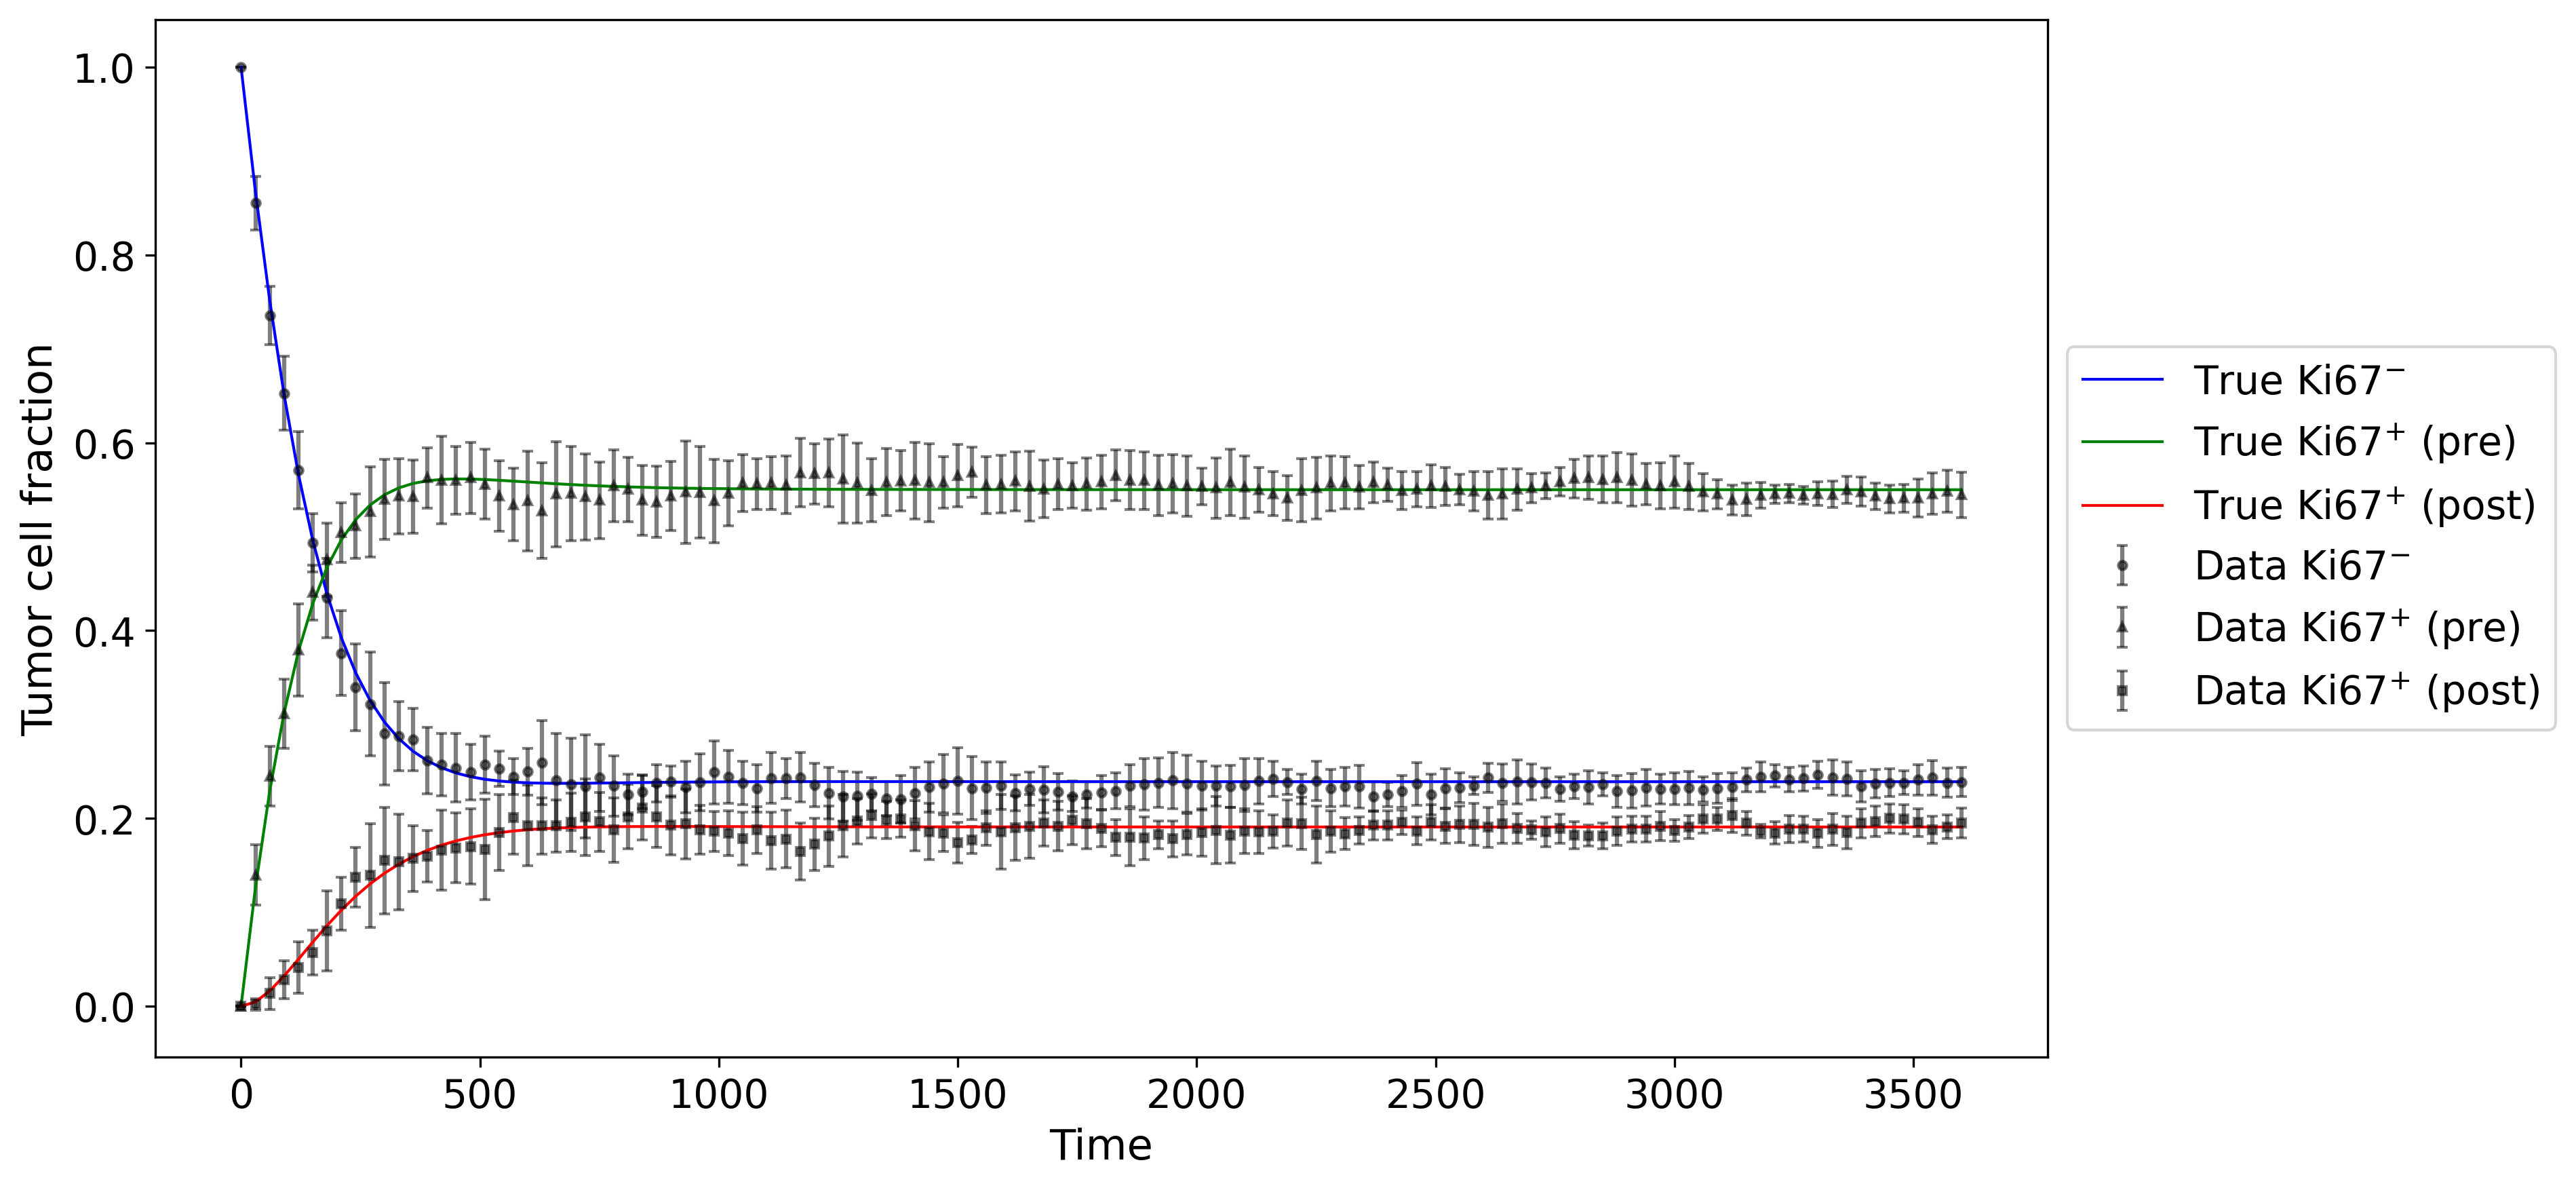

In [93]:
plt.clf()
plt.rcParams.update({'font.size': 14})
plt.subplots(1, 1, figsize = (12, 6.75), dpi = 300)
if cycle_model == 0:
    plt.errorbar(times, Ki67_negative_data, yerr = Ki67_negative_data_std[:,0], fmt = 'ko', label = r"Data Ki67$^{-}$", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, Ki67_positive_premitotic_data, yerr = Ki67_positive_premitotic_data_std[:,0], fmt = 'k^', label = r"Data Ki67$^{+}$ (pre)", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, Ki67_positive_postmitotic_data, yerr = Ki67_positive_postmitotic_data_std[:,0], fmt = 'ks', label = r"Data Ki67$^{+}$ (post)", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, Ki67_negative_true, "b", label = r"True Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_premitotic_true, "g", label = r"True Ki67$^{+}$ (pre)", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_postmitotic_true, "r", label = r"True Ki67$^{+}$ (post)", alpha = 1.0, linewidth = 1)
elif cycle_model == 1:
    plt.errorbar(times, Ki67_negative_data, yerr = Ki67_negative_data_std[:,0], fmt = 'ko', label = r"Data Ki67$^{-}$", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, Ki67_positive_data, yerr = Ki67_positive_data_std[:,0], fmt = 'k^', label = r"Data Ki67$^{+}$", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, Ki67_negative_true, "b", label = r"True Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_true, "g", label = r"True Ki67$^{+}$", alpha = 1.0, linewidth = 1)
elif cycle_model == 2:
    plt.errorbar(times, G0G1_phase_data, yerr = G0G1_phase_data_std[:,0], fmt = 'ko', label = r"Data G0/G1", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, S_phase_data, yerr = S_phase_data_std[:,0], fmt = 'k^', label = r"Data S", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, G2M_phase_data, yerr = G2M_phase_data_std[:,0], fmt = 'ks', label = r"Data G2/M", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, G0G1_phase_true, "b", label = r"True G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_true, "g", label = r"True S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2M_phase_true, "r", label = r"True G2/M", alpha = 1.0, linewidth = 1)
elif cycle_model == 5:
    plt.errorbar(times, live_data, yerr = live_data_std[:,0], fmt = 'ko', label = r"Data Live", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, live_true, "b", label = r"True Live", alpha = 1.0, linewidth = 1)
elif cycle_model == 6:
    plt.errorbar(times, G0G1_phase_data, yerr = G0G1_phase_data_std[:,0], fmt = 'ko', label = r"Data G0/G1", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, S_phase_data, yerr = S_phase_data_std[:,0], fmt = 'k^', label = r"Data S", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, G2_phase_data, yerr = G2_phase_data_std[:,0], fmt = 'ks', label = r"Data G2", capsize = 2.0, alpha = 0.5, markersize = 3)
    plt.errorbar(times, M_phase_data, yerr = M_phase_data_std[:,0], fmt = 'kD', label = r"Data M", capsize = 2.0, alpha = 0.5, markersize = 3)
    
    plt.plot(times, G0G1_phase_true, "b", label = r"True G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_true, "g", label = r"True S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2_phase_true, "r", label = r"True G2", alpha = 1.0, linewidth = 1)
    plt.plot(times, M_phase_true, "m", label = r"True M", alpha = 1.0, linewidth = 1)
else:
    print("Unrecognized cell cycle model.")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.title( 'Comparison of the tumor cell fraction', size=20)
plt.xlabel( 'Time', size=15 ) 
plt.ylabel( 'Tumor cell fraction', size=15 )
plt.savefig(os.path.join(output_folder, "fraction_comparison.pdf"), bbox_inches = 'tight')

## Compute cumulative sum of squared errors between data and true model

In [62]:
def compute_CSSE(target, predicted):
    squared_errors = (target - predicted)**2.0
    return np.cumsum(squared_errors)

In [63]:
if cycle_model == 0:
    Ki67_negative_csse = compute_CSSE(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_premitotic_csse = compute_CSSE(Ki67_positive_premitotic_true.flatten(), Ki67_positive_premitotic_data.flatten());
    Ki67_positive_postmitotic_csse = compute_CSSE(Ki67_positive_postmitotic_true.flatten(), Ki67_positive_postmitotic_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([Ki67_negative_csse[-1], Ki67_positive_premitotic_csse[-1], Ki67_positive_postmitotic_csse[-1]])) + "\n")
elif cycle_model == 1:
    Ki67_negative_csse = compute_CSSE(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_csse = compute_CSSE(Ki67_positive_true.flatten(), Ki67_positive_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([Ki67_negative_csse[-1], Ki67_positive_csse[-1]])) + "\n")
elif cycle_model == 2:
    G0G1_phase_csse = compute_CSSE(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_csse = compute_CSSE(S_phase_true.flatten(), S_phase_data.flatten());
    G2M_phase_csse = compute_CSSE(G2M_phase_true.flatten(), G2M_phase_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([G0G1_phase_csse[-1], S_phase_csse[-1], G2M_phase_csse[-1]])) + "\n")
elif cycle_model == 5:
    live_csse = compute_CSSE(live_true.flatten(), live_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([live_csse[-1]])) + "\n")
elif cycle_model == 6:
    G0G1_phase_csse = compute_CSSE(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_csse = compute_CSSE(S_phase_true.flatten(), S_phase_data.flatten());
    G2_phase_csse = compute_CSSE(G2_phase_true.flatten(), G2_phase_data.flatten());
    M_phase_csse = compute_CSSE(M_phase_true.flatten(), M_phase_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([G0G1_phase_csse[-1], S_phase_csse[-1], G2_phase_csse[-1], M_phase_csse[-1]])) + "\n")
else:
    print("Unrecognized cell cycle model.")

SSE between data and true model = [0.00160598 0.00174307 0.00166586]



## Plot cumulative sum of squared errors

<Figure size 432x288 with 0 Axes>

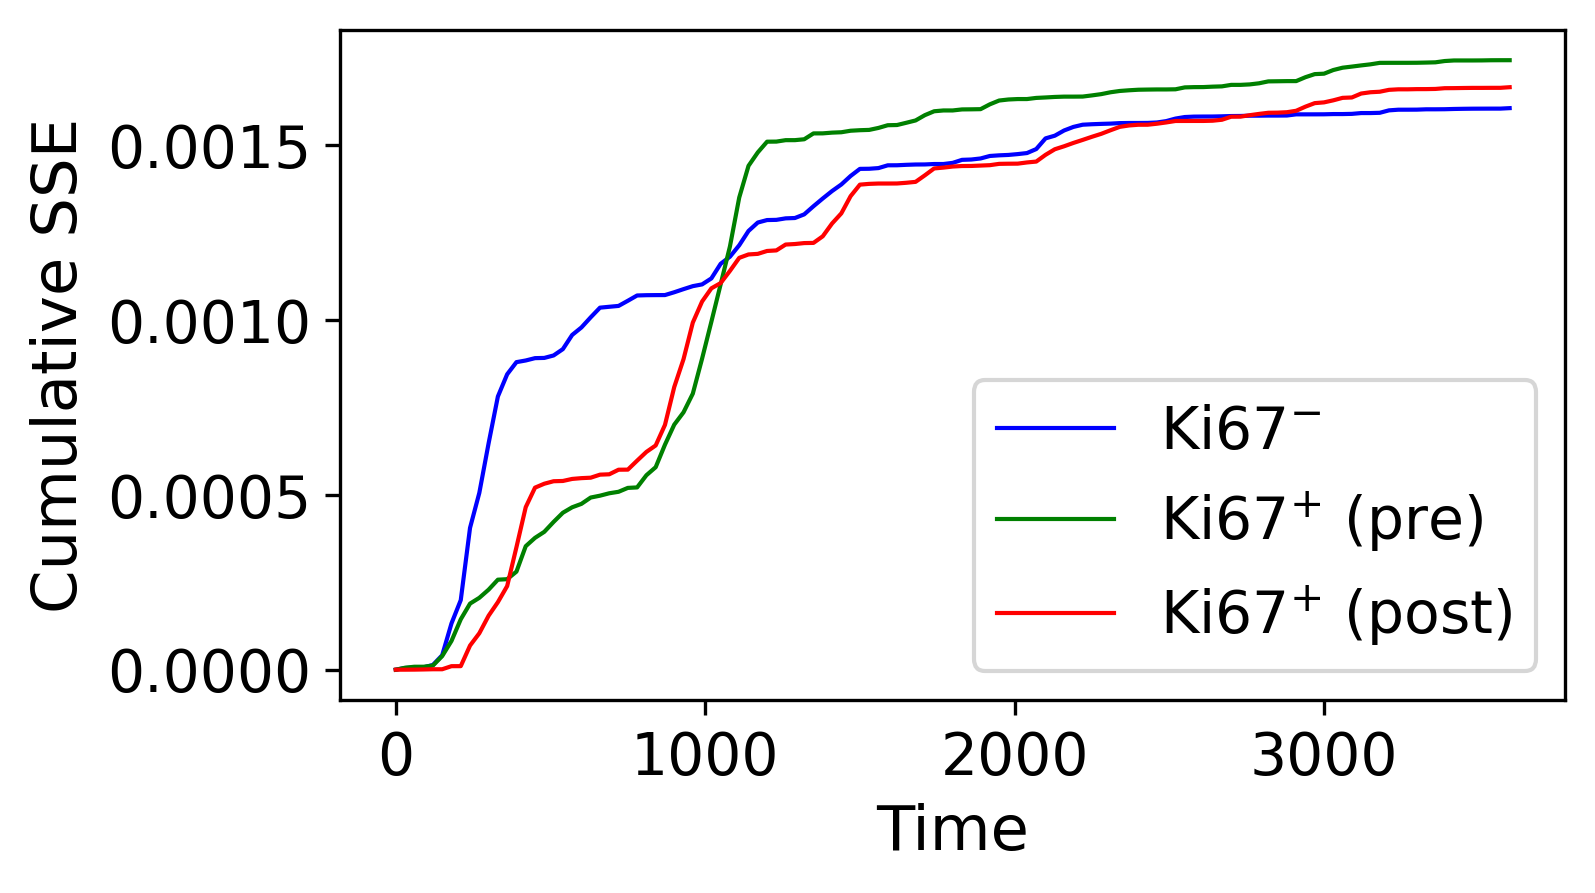

In [64]:
plt.clf()
plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
if cycle_model == 0:
    plt.plot(times, Ki67_negative_csse, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_premitotic_csse, "g", label = r"Ki67$^{+}$ (pre)", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_postmitotic_csse, "r", label = r"Ki67$^{+}$ (post)", alpha = 1.0, linewidth = 1)
elif cycle_model == 1:
    plt.plot(times, Ki67_negative_csse, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_csse, "g", label = r"Ki67$^{+}$", alpha = 1.0, linewidth = 1)
elif cycle_model == 2:
    plt.plot(times, G0G1_phase_csse, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_csse, "g", label = r"S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2M_phase_csse, "r", label = r"G2/M", alpha = 1.0, linewidth = 1)
elif cycle_model == 5:
    plt.plot(times, live_csse, "b", label = r"Live", alpha = 1.0, linewidth = 1)
elif cycle_model == 6:
    plt.plot(times, G0G1_phase_csse, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_csse, "g", label = r"S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2_phase_csse, "r", label = r"G2", alpha = 1.0, linewidth = 1)
    plt.plot(times, M_phase_csse, "m", label = r"M", alpha = 1.0, linewidth = 1)
else:
    print("Unrecognized cell cycle model.")
plt.legend()
    
# plt.title( 'Cumulative SSE between data and model', size=20)
plt.xlabel( 'Time', size=15 ) 
plt.ylabel( 'Cumulative SSE', size=15 )
plt.savefig(os.path.join(output_folder, "csse.pdf"), bbox_inches = 'tight')

## Write a *.csv* output file

In [65]:
if cycle_model == 0:
    output_array = np.column_stack((times.flatten(), Ki67_negative_csse.flatten(), Ki67_positive_premitotic_csse.flatten(), Ki67_positive_postmitotic_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, Ki67_negative_csse, Ki67_positive_premitotic_csse, Ki67_positive_postmitotic_csse", comments='')
elif cycle_model == 1:
    output_array = np.column_stack((times.flatten(), Ki67_negative_csse.flatten(), Ki67_positive_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, Ki67_negative_csse, Ki67_positive_csse", comments='')
elif cycle_model == 2:
    output_array = np.column_stack((times.flatten(), G0G1_phase_csse.flatten(), S_phase_csse.flatten(), G2M_phase_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, G0G1_phase_csse, S_phase_csse, G2M_phase_csse", comments='')
elif cycle_model == 5:
    output_array = np.column_stack((times.flatten(), live_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, live_csse", comments='')
elif cycle_model == 6:
    output_array = np.column_stack((times.flatten(), G0G1_phase_csse.flatten(), S_phase_csse.flatten(), G2_phase_csse.flatten(), M_phase_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, G0G1_phase_csse, S_phase_csse, G2_phase_csse, M_phase_csse", comments='')
else:
    print("Unrecognized cell cycle model.")

## Compute cumulative sum of squared errors between data and true model after $t=720$ min

In [66]:
# ref_time = 720.0
# time_inds = np.where(times >= ref_time)

# if cycle_model == 0:
#     Ki67_negative_csse = compute_CSSE(Ki67_negative_true[time_inds].flatten(), Ki67_negative_data[time_inds].flatten());
#     Ki67_positive_premitotic_csse = compute_CSSE(Ki67_positive_premitotic_true[time_inds].flatten(), Ki67_positive_premitotic_data[time_inds].flatten());
#     Ki67_positive_postmitotic_csse = compute_CSSE(Ki67_positive_postmitotic_true[time_inds].flatten(), Ki67_positive_postmitotic_data[time_inds].flatten());
    
#     print("SSE between data and true model = " + str(np.array([Ki67_negative_csse[-1], Ki67_positive_premitotic_csse[-1], Ki67_positive_postmitotic_csse[-1]])) + "\n")
# elif cycle_model == 1:
#     Ki67_negative_csse = compute_CSSE(Ki67_negative_true[time_inds].flatten(), Ki67_negative_data[time_inds].flatten());
#     Ki67_positive_csse = compute_CSSE(Ki67_positive_true[time_inds].flatten(), Ki67_positive_data[time_inds].flatten());
    
#     print("SSE between data and true model = " + str(np.array([Ki67_negative_csse[-1], Ki67_positive_csse[-1]])) + "\n")
# elif cycle_model == 2:
#     G0G1_phase_csse = compute_CSSE(G0G1_phase_true[time_inds].flatten(), G0G1_phase_data[time_inds].flatten());
#     S_phase_csse = compute_CSSE(S_phase_true[time_inds].flatten(), S_phase_data[time_inds].flatten());
#     G2M_phase_csse = compute_CSSE(G2M_phase_true[time_inds].flatten(), G2M_phase_data[time_inds].flatten());
    
#     print("SSE between data and true model = " + str(np.array([G0G1_phase_csse[-1], S_phase_csse[-1], G2M_phase_csse[-1]])) + "\n")
# elif cycle_model == 5:
#     live_csse = compute_CSSE(live_true[time_inds].flatten(), live_data[time_inds].flatten());
    
#     print("SSE between data and true model = " + str(np.array([live_csse[-1]])) + "\n")
# elif cycle_model == 6:
#     G0G1_phase_csse = compute_CSSE(G0G1_phase_true[time_inds].flatten(), G0G1_phase_data[time_inds].flatten());
#     S_phase_csse = compute_CSSE(S_phase_true[time_inds].flatten(), S_phase_data[time_inds].flatten());
#     G2_phase_csse = compute_CSSE(G2_phase_true[time_inds].flatten(), G2_phase_data[time_inds].flatten());
#     M_phase_csse = compute_CSSE(M_phase_true[time_inds].flatten(), M_phase_data[time_inds].flatten());
    
#     print("SSE between data and true model = " + str(np.array([G0G1_phase_csse[-1], S_phase_csse[-1], G2_phase_csse[-1], M_phase_csse[-1]])) + "\n")
# else:
#     print("Unrecognized cell cycle model.")

## Plot cumulative sum of squared errors after $t=720$ min

In [67]:
# plt.clf()
# plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
# if cycle_model == 0:
#     plt.plot(times[time_inds], Ki67_negative_csse, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], Ki67_positive_premitotic_csse, "g", label = r"Ki67$^{+}$ (pre)", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], Ki67_positive_postmitotic_csse, "r", label = r"Ki67$^{+}$ (post)", alpha = 1.0, linewidth = 1)
# elif cycle_model == 1:
#     plt.plot(times[time_inds], Ki67_negative_csse, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], Ki67_positive_csse, "g", label = r"Ki67$^{+}$", alpha = 1.0, linewidth = 1)
# elif cycle_model == 2:
#     plt.plot(times[time_inds], G0G1_phase_csse, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], S_phase_csse, "g", label = r"S", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], G2M_phase_csse, "r", label = r"G2/M", alpha = 1.0, linewidth = 1)
# elif cycle_model == 5:
#     plt.plot(times[time_inds], live_csse, "b", label = r"Live", alpha = 1.0, linewidth = 1)
# elif cycle_model == 6:
#     plt.plot(times[time_inds], G0G1_phase_csse, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], S_phase_csse, "g", label = r"S", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], G2_phase_csse, "r", label = r"G2", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], M_phase_csse, "m", label = r"M", alpha = 1.0, linewidth = 1)
# else:
#     print("Unrecognized cell cycle model.")
# plt.legend()
    
# # plt.title( 'Cumulative SSE between data and true model\n (after t=' + str(ref_time) + ' min)', size=20)
# plt.xlabel( 'Time', size=15 ) 
# plt.ylabel( 'Cumulative SSE', size=15 )
# plt.savefig(os.path.join(output_folder, "csse" + str(ref_time) + ".pdf"), bbox_inches = 'tight')

## Write a *.csv* output file

In [68]:
# if cycle_model == 0:
#     output_array = np.column_stack((times[time_inds].flatten(), Ki67_negative_csse.flatten(), Ki67_positive_premitotic_csse.flatten(), Ki67_positive_postmitotic_csse.flatten()))
#     np.savetxt(os.path.join(output_folder, "csse" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, Ki67_negative_csse, Ki67_positive_premitotic_csse, Ki67_positive_postmitotic_csse", comments='')
# elif cycle_model == 1:
#     output_array = np.column_stack((times[time_inds].flatten(), Ki67_negative_csse.flatten(), Ki67_positive_csse.flatten()))
#     np.savetxt(os.path.join(output_folder, "csse" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, Ki67_negative_csse, Ki67_positive_csse", comments='')
# elif cycle_model == 2:
#     output_array = np.column_stack((times[time_inds].flatten(), G0G1_phase_csse.flatten(), S_phase_csse.flatten(), G2M_phase_csse.flatten()))
#     np.savetxt(os.path.join(output_folder, "csse" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, G0G1_phase_csse, S_phase_csse, G2M_phase_csse", comments='')
# elif cycle_model == 5:
#     output_array = np.column_stack((times[time_inds].flatten(), live_csse.flatten()))
#     np.savetxt(os.path.join(output_folder, "csse" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, live_csse", comments='')
# elif cycle_model == 6:
#     output_array = np.column_stack((times[time_inds].flatten(), G0G1_phase_csse.flatten(), S_phase_csse.flatten(), G2_phase_csse.flatten(), M_phase_csse.flatten()))
#     np.savetxt(os.path.join(output_folder, "csse" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, G0G1_phase_csse, S_phase_csse, G2_phase_csse, M_phase_csse", comments='')
# else:
#     print("Unrecognized cell cycle model.")

## Compute absolute error between data and true model

In [69]:
def compute_absolute_error(target, predicted):
    absolute_errors = abs(target - predicted)
    return np.cumsum(absolute_errors)

In [70]:
if cycle_model == 0:
    Ki67_negative_absolute_error = compute_absolute_error(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_premitotic_absolute_error = compute_absolute_error(Ki67_positive_premitotic_true.flatten(), Ki67_positive_premitotic_data.flatten());
    Ki67_positive_postmitotic_absolute_error = compute_absolute_error(Ki67_positive_postmitotic_true.flatten(), Ki67_positive_postmitotic_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([Ki67_negative_absolute_error[-1], Ki67_positive_premitotic_absolute_error[-1], Ki67_positive_postmitotic_absolute_error[-1]])) + "\n")
elif cycle_model == 1:
    Ki67_negative_absolute_error = compute_absolute_error(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_absolute_error = compute_absolute_error(Ki67_positive_true.flatten(), Ki67_positive_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([Ki67_negative_absolute_error[-1], Ki67_positive_absolute_error[-1]])) + "\n")
elif cycle_model == 2:
    G0G1_phase_absolute_error = compute_absolute_error(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_absolute_error = compute_absolute_error(S_phase_true.flatten(), S_phase_data.flatten());
    G2M_phase_absolute_error = compute_absolute_error(G2M_phase_true.flatten(), G2M_phase_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([G0G1_phase_absolute_error[-1], S_phase_absolute_error[-1], G2M_phase_absolute_error[-1]])) + "\n")
elif cycle_model == 5:
    live_absolute_error = compute_absolute_error(live_true.flatten(), live_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([live_absolute_error[-1]])) + "\n")
elif cycle_model == 6:
    G0G1_phase_absolute_error = compute_absolute_error(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_absolute_error = compute_absolute_error(S_phase_true.flatten(), S_phase_data.flatten());
    G2_phase_absolute_error = compute_absolute_error(G2_phase_true.flatten(), G2_phase_data.flatten());
    M_phase_absolute_error = compute_absolute_error(M_phase_true.flatten(), M_phase_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([G0G1_phase_absolute_error[-1], S_phase_absolute_error[-1], G2_phase_absolute_error[-1], M_phase_absolute_error[-1]])) + "\n")
else:
    print("Unrecognized cell cycle model.")

Absolute error between data and true model = [0.30079102 0.32602638 0.32785108]



## Plot absolute error

<Figure size 432x288 with 0 Axes>

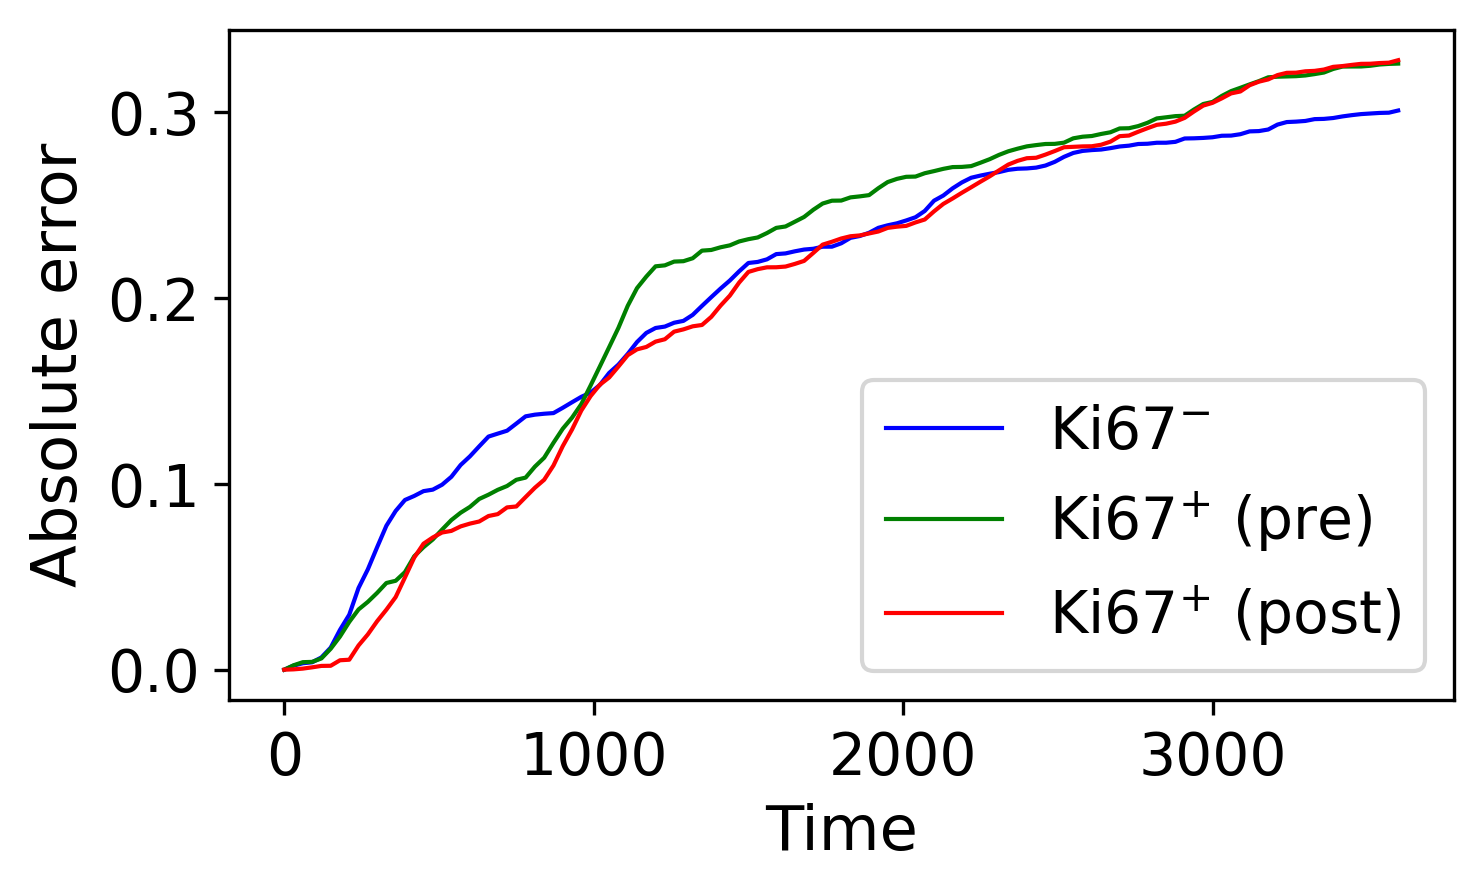

In [71]:
plt.clf()
plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
if cycle_model == 0:
    plt.plot(times, Ki67_negative_absolute_error, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_premitotic_absolute_error, "g", label = r"Ki67$^{+}$ (pre)", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_postmitotic_absolute_error, "r", label = r"Ki67$^{+}$ (post)", alpha = 1.0, linewidth = 1)
elif cycle_model == 1:
    plt.plot(times, Ki67_negative_absolute_error, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
    plt.plot(times, Ki67_positive_absolute_error, "g", label = r"Ki67$^{+}$", alpha = 1.0, linewidth = 1)
elif cycle_model == 2:
    plt.plot(times, G0G1_phase_absolute_error, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_absolute_error, "g", label = r"S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2M_phase_absolute_error, "r", label = r"G2/M", alpha = 1.0, linewidth = 1)
elif cycle_model == 5:
    plt.plot(times, live_absolute_error, "b", label = r"Live", alpha = 1.0, linewidth = 1)
elif cycle_model == 6:
    plt.plot(times, G0G1_phase_absolute_error, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
    plt.plot(times, S_phase_absolute_error, "g", label = r"S", alpha = 1.0, linewidth = 1)
    plt.plot(times, G2_phase_absolute_error, "r", label = r"G2", alpha = 1.0, linewidth = 1)
    plt.plot(times, M_phase_absolute_error, "m", label = r"M", alpha = 1.0, linewidth = 1)
else:
    print("Unrecognized cell cycle model.")
plt.legend()
    
# plt.title( 'Absolute error between data and true model', size=20)
plt.xlabel( 'Time', size=15 ) 
plt.ylabel( 'Absolute error', size=15 )
plt.savefig(os.path.join(output_folder, "absolute_error.pdf"), bbox_inches = 'tight')

## Write a *.csv* output file

In [72]:
if cycle_model == 0:
    output_array = np.column_stack((times.flatten(), Ki67_negative_absolute_error.flatten(), Ki67_positive_premitotic_absolute_error.flatten(), Ki67_positive_postmitotic_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, Ki67_negative_absolute_error, Ki67_positive_premitotic_absolute_error, Ki67_positive_postmitotic_absolute_error", comments='')
elif cycle_model == 1:
    output_array = np.column_stack((times.flatten(), Ki67_negative_absolute_error.flatten(), Ki67_positive_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, Ki67_negative_absolute_error, Ki67_positive_absolute_error", comments='')
elif cycle_model == 2:
    output_array = np.column_stack((times.flatten(), G0G1_phase_absolute_error.flatten(), S_phase_absolute_error.flatten(), G2M_phase_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, G0G1_phase_absolute_error, S_phase_absolute_error, G2M_phase_absolute_error", comments='')
elif cycle_model == 5:
    output_array = np.column_stack((times.flatten(), live_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, live_absolute_error", comments='')
elif cycle_model == 6:
    output_array = np.column_stack((times.flatten(), G0G1_phase_absolute_error.flatten(), S_phase_absolute_error.flatten(), G2_phase_absolute_error.flatten(), M_phase_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, G0G1_phase_absolute_error, S_phase_absolute_error, G2_phase_absolute_error, M_phase_absolute_error", comments='')
else:
    print("Unrecognized cell cycle model.")

## Compute absolute error between data and true model after $t=720$ min

In [73]:
# if cycle_model == 0:
#     Ki67_negative_absolute_error = compute_absolute_error(Ki67_negative_true[time_inds].flatten(), Ki67_negative_data[time_inds].flatten());
#     Ki67_positive_premitotic_absolute_error = compute_absolute_error(Ki67_positive_premitotic_true[time_inds].flatten(), Ki67_positive_premitotic_data[time_inds].flatten());
#     Ki67_positive_postmitotic_absolute_error = compute_absolute_error(Ki67_positive_postmitotic_true[time_inds].flatten(), Ki67_positive_postmitotic_data[time_inds].flatten());
    
#     print("Absolute error between data and true model = " + str(np.array([Ki67_negative_absolute_error[-1], Ki67_positive_premitotic_absolute_error[-1], Ki67_positive_postmitotic_absolute_error[-1]])) + "\n")
# elif cycle_model == 1:
#     Ki67_negative_absolute_error = compute_absolute_error(Ki67_negative_true[time_inds].flatten(), Ki67_negative_data[time_inds].flatten());
#     Ki67_positive_absolute_error = compute_absolute_error(Ki67_positive_true[time_inds].flatten(), Ki67_positive_data[time_inds].flatten());
    
#     print("Absolute error between data and true model = " + str(np.array([Ki67_negative_absolute_error[-1], Ki67_positive_absolute_error[-1]])) + "\n")
# elif cycle_model == 2:
#     G0G1_phase_absolute_error = compute_absolute_error(G0G1_phase_true[time_inds].flatten(), G0G1_phase_data[time_inds].flatten());
#     S_phase_absolute_error = compute_absolute_error(S_phase_true[time_inds].flatten(), S_phase_data[time_inds].flatten());
#     G2M_phase_absolute_error = compute_absolute_error(G2M_phase_true[time_inds].flatten(), G2M_phase_data[time_inds].flatten());
    
#     print("Absolute error between data and true model = " + str(np.array([G0G1_phase_absolute_error[-1], S_phase_absolute_error[-1], G2M_phase_absolute_error[-1]])) + "\n")
# elif cycle_model == 5:
#     live_absolute_error = compute_absolute_error(live_true[time_inds].flatten(), live_data[time_inds].flatten());
    
#     print("Absolute error between data and true model = " + str(np.array([live_absolute_error[-1]])) + "\n")
# elif cycle_model == 6:
#     G0G1_phase_absolute_error = compute_absolute_error(G0G1_phase_true[time_inds].flatten(), G0G1_phase_data[time_inds].flatten());
#     S_phase_absolute_error = compute_absolute_error(S_phase_true[time_inds].flatten(), S_phase_data[time_inds].flatten());
#     G2_phase_absolute_error = compute_absolute_error(G2_phase_true[time_inds].flatten(), G2_phase_data[time_inds].flatten());
#     M_phase_absolute_error = compute_absolute_error(M_phase_true[time_inds].flatten(), M_phase_data[time_inds].flatten());
    
#     print("Absolute error between data and true model = " + str(np.array([G0G1_phase_absolute_error[-1], S_phase_absolute_error[-1], G2_phase_absolute_error[-1], M_phase_absolute_error[-1]])) + "\n")
# else:
#     print("Unrecognized cell cycle model.")

## Plot absolute error after $t=720$ min

In [74]:
# plt.clf()
# plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
# if cycle_model == 0:
#     plt.plot(times[time_inds], Ki67_negative_absolute_error, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], Ki67_positive_premitotic_absolute_error, "g", label = r"Ki67$^{+}$ (pre)", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], Ki67_positive_postmitotic_absolute_error, "r", label = r"Ki67$^{+}$ (post)", alpha = 1.0, linewidth = 1)
# elif cycle_model == 1:
#     plt.plot(times[time_inds], Ki67_negative_absolute_error, "b", label = r"Ki67$^{-}$", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], Ki67_positive_absolute_error, "g", label = r"Ki67$^{+}$", alpha = 1.0, linewidth = 1)
# elif cycle_model == 2:
#     plt.plot(times[time_inds], G0G1_phase_absolute_error, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], S_phase_absolute_error, "g", label = r"S", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], G2M_phase_absolute_error, "r", label = r"G2/M", alpha = 1.0, linewidth = 1)
# elif cycle_model == 5:
#     plt.plot(times[time_inds], live_absolute_error, "b", label = r"Live", alpha = 1.0, linewidth = 1)
# elif cycle_model == 6:
#     plt.plot(times[time_inds], G0G1_phase_absolute_error, "b", label = r"G0/G1", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], S_phase_absolute_error, "g", label = r"S", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], G2_phase_absolute_error, "r", label = r"G2", alpha = 1.0, linewidth = 1)
#     plt.plot(times[time_inds], M_phase_absolute_error, "m", label = r"M", alpha = 1.0, linewidth = 1)
# else:
#     print("Unrecognized cell cycle model.")
# plt.legend()
    
# # plt.title( 'Absolute error between data and true model\n (after t=' + str(ref_time) + ' min)', size=20)
# plt.xlabel( 'Time', size=15 ) 
# plt.ylabel( 'Absolute error', size=15 )
# plt.savefig(os.path.join(output_folder, "absolute_error" + str(ref_time) + ".pdf"), bbox_inches = 'tight')

## Write a *.csv* output file

In [75]:
# if cycle_model == 0:
#     output_array = np.column_stack((times[time_inds].flatten(), Ki67_negative_absolute_error.flatten(), Ki67_positive_premitotic_absolute_error.flatten(), Ki67_positive_postmitotic_absolute_error.flatten()))
#     np.savetxt(os.path.join(output_folder, "absolute_error" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, Ki67_negative_absolute_error, Ki67_positive_premitotic_absolute_error, Ki67_positive_postmitotic_absolute_error", comments='')
# elif cycle_model == 1:
#     output_array = np.column_stack((times[time_inds].flatten(), Ki67_negative_absolute_error.flatten(), Ki67_positive_absolute_error.flatten()))
#     np.savetxt(os.path.join(output_folder, "absolute_error" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, Ki67_negative_absolute_error, Ki67_positive_absolute_error", comments='')
# elif cycle_model == 2:
#     output_array = np.column_stack((times[time_inds].flatten(), G0G1_phase_absolute_error.flatten(), S_phase_absolute_error.flatten(), G2M_phase_absolute_error.flatten()))
#     np.savetxt(os.path.join(output_folder, "absolute_error" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, G0G1_phase_absolute_error, S_phase_absolute_error, G2M_phase_absolute_error", comments='')
# elif cycle_model == 5:
#     output_array = np.column_stack((times[time_inds].flatten(), live_absolute_error.flatten()))
#     np.savetxt(os.path.join(output_folder, "absolute_error" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, live_absolute_error", comments='')
# elif cycle_model == 6:
#     output_array = np.column_stack((times[time_inds].flatten(), G0G1_phase_absolute_error.flatten(), S_phase_absolute_error.flatten(), G2_phase_absolute_error.flatten(), M_phase_absolute_error.flatten()))
#     np.savetxt(os.path.join(output_folder, "absolute_error" + str(ref_time) + ".csv"), output_array, delimiter=',', fmt='%.8f',
#                header="times, G0G1_phase_absolute_error, S_phase_absolute_error, G2_phase_absolute_error, M_phase_absolute_error", comments='')
# else:
#     print("Unrecognized cell cycle model.")

## Compute squared error between data and true model at the final simulation time

In [76]:
def compute_squared_error(target, predicted):
    return (target - predicted)**2.0

In [77]:
if cycle_model == 0:
    Ki67_negative_squared_error = compute_squared_error(Ki67_negative_true[-1], Ki67_negative_data[-1]);
    Ki67_positive_premitotic_squared_error = compute_squared_error(Ki67_positive_premitotic_true[-1], Ki67_positive_premitotic_data[-1]);
    Ki67_positive_postmitotic_squared_error = compute_squared_error(Ki67_positive_postmitotic_true[-1], Ki67_positive_postmitotic_data[-1]);
    
    print("SSE between data and true model = " + str(np.array([Ki67_negative_squared_error[-1], Ki67_positive_premitotic_squared_error[-1], Ki67_positive_postmitotic_squared_error[-1]])) + "\n")
elif cycle_model == 1:
    Ki67_negative_squared_error = compute_squared_error(Ki67_negative_true[-1], Ki67_negative_data[-1]);
    Ki67_positive_squared_error = compute_squared_error(Ki67_positive_true[-1], Ki67_positive_data[-1]);
    
    print("SSE between data and true model = " + str(np.array([Ki67_negative_squared_error[-1], Ki67_positive_squared_error[-1]])) + "\n")
elif cycle_model == 2:
    G0G1_phase_squared_error = compute_squared_error(G0G1_phase_true[-1], G0G1_phase_data[-1]);
    S_phase_squared_error = compute_squared_error(S_phase_true[-1], S_phase_data[-1]);
    G2M_phase_squared_error = compute_squared_error(G2M_phase_true[-1], G2M_phase_data[-1]);
    
    print("SSE between data and true model = " + str(np.array([G0G1_phase_squared_error[-1], S_phase_squared_error[-1], G2M_phase_squared_error[-1]])) + "\n")
elif cycle_model == 5:
    live_squared_error = compute_squared_error(live_true[-1], live_data[-1]);
    
    print("SSE between data and true model = " + str(np.array([live_squared_error[-1]])) + "\n")
elif cycle_model == 6:
    G0G1_phase_squared_error = compute_squared_error(G0G1_phase_true[-1], G0G1_phase_data[-1]);
    S_phase_squared_error = compute_squared_error(S_phase_true[-1], S_phase_data[-1]);
    G2_phase_squared_error = compute_squared_error(G2_phase_true[-1], G2_phase_data[-1]);
    M_phase_squared_error = compute_squared_error(M_phase_true[-1], M_phase_data[-1]);
    
    print("SSE between data and true model = " + str(np.array([G0G1_phase_squared_error[-1], S_phase_squared_error[-1], G2_phase_squared_error[-1], M_phase_squared_error[-1]])) + "\n")
else:
    print("Unrecognized cell cycle model.")

SSE between data and true model = [1.37987595e-06 2.67167536e-08 1.79060211e-06]



## Write a *.csv* output file

In [78]:
if cycle_model == 0:
    output_array = np.column_stack((Ki67_negative_squared_error.flatten(), Ki67_positive_premitotic_squared_error.flatten(), Ki67_positive_postmitotic_squared_error.flatten()))
    np.savetxt(os.path.join(output_folder, "squared_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="Ki67_negative_squared_error, Ki67_positive_premitotic_squared_error, Ki67_positive_postmitotic_squared_error", comments='')
elif cycle_model == 1:
    output_array = np.column_stack((Ki67_negative_squared_error.flatten(), Ki67_positive_squared_error.flatten()))
    np.savetxt(os.path.join(output_folder, "squared_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="Ki67_negative_squared_error, Ki67_positive_squared_error", comments='')
elif cycle_model == 2:
    output_array = np.column_stack((G0G1_phase_squared_error.flatten(), S_phase_squared_error.flatten(), G2M_phase_squared_error.flatten()))
    np.savetxt(os.path.join(output_folder, "squared_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="G0G1_phase_squared_error, S_phase_squared_error, G2M_phase_squared_error", comments='')
elif cycle_model == 5:
    output_array = np.column_stack((live_squared_error.flatten(),))
    np.savetxt(os.path.join(output_folder, "squared_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="live_squared_error", comments='')
elif cycle_model == 6:
    output_array = np.column_stack((G0G1_phase_squared_error.flatten(), S_phase_squared_error.flatten(), G2_phase_squared_error.flatten(), M_phase_squared_error.flatten()))
    np.savetxt(os.path.join(output_folder, "squared_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="G0G1_phase_squared_error, S_phase_squared_error, G2_phase_squared_error, M_phase_squared_error", comments='')
else:
    print("Unrecognized cell cycle model.")